In [44]:
import tensorflow as tf
import numpy as np

dir_path = './datasets/MP_1'

def load_dataset():
    # Load images and labels
    images = []
    labels = []

    shape = (62, 108, 3)
    
    for filename in os.listdir(os.path.join(dir_path)):
        img = cv2.imread(os.path.join(dir_path, filename), cv2.COLOR_BGR2RGB)
        if img is not None and img.shape == shape:
            images.append(img)
            
            if 'false' in filename:
                labels.append(0)
            else:
                labels.append(1)
    
    X = np.array(images)
    y = np.array(labels)
    
    X = X[..., np.newaxis]
    
    return X, y

# Define different augmentations
def flip_left_right(image):
    return tf.image.random_flip_left_right(image)

def flip_up_down(image):
    return tf.image.random_flip_up_down(image)

def brightness(image):
    return tf.image.random_brightness(image, max_delta=0.1)

def contrast(image):
    return tf.image.random_contrast(image, lower=0.1, upper=0.2)

def saturation(image):
    return tf.image.random_saturation(image, lower=0.5, upper=1.5)

def hue(image):
    return tf.image.random_hue(image, max_delta=0.2)

def central_crop(image):
    return tf.image.central_crop(image, central_fraction=0.8)

# List of augmentation functions
augmentations = [flip_left_right, flip_up_down, brightness, contrast, saturation, hue]

def random_augment(image):
    # Randomly select and apply an augmentation function
    augment = np.random.choice(augmentations)
    return augment(image)

X, y = load_dataset()

# Convert to TensorFlow Dataset
dataset = tf.data.Dataset.from_tensor_slices((X, y))

# Create augmented datasets and concatenate to the original dataset
combined_dataset = dataset
for _ in range(2):  # Increase to desired multiple, 2 for triple size
    augmented_dataset = dataset.map(lambda x, y: (random_augment(x), y))
    combined_dataset = combined_dataset.concatenate(augmented_dataset)

In [47]:
# Convert the combined_dataset back to X, y
X_list = []
y_list = []

# Iterate over the combined_dataset
for images, labels in combined_dataset:
    X_list.append(images.numpy())
    y_list.append(labels.numpy())

# Convert lists to numpy arrays
X = np.array(X_list)
y = np.array(y_list)

X.shape, y.shape

((1014, 62, 108, 3, 1), (1014,))

In [48]:
from sklearn.model_selection import train_test_split

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [50]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, GlobalMaxPooling2D
from keras.datasets import mnist
from keras.utils import to_categorical

# Create a CNN model
model = Sequential()

# Add a convolution layer
model.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=(62, 108, 3)))

# Add a max pooling layer
model.add(MaxPooling2D(pool_size=(2, 2)))

# Add another convolution layer
model.add(Conv2D(64, kernel_size=3, activation='relu'))

# Add another max pooling layer
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the tensor output from the previous layer
model.add(Flatten())
# Replace the Flatten layer with GlobalMaxPooling2D
#model.add(GlobalMaxPooling2D())

# Add a dense layer
model.add(Dense(64, activation='relu'))

# Add output layer
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10)

Epoch 1/15
26/26 [==============================] - 12s 348ms/step - loss: 38.6707 - accuracy: 0.6264 - val_loss: 0.4027 - val_accuracy: 0.8768
Epoch 2/15
26/26 [==============================] - 9s 340ms/step - loss: 0.2301 - accuracy: 0.9248 - val_loss: 0.0988 - val_accuracy: 0.9606
Epoch 3/15
26/26 [==============================] - 9s 339ms/step - loss: 0.0388 - accuracy: 0.9914 - val_loss: 0.0439 - val_accuracy: 0.9803
Epoch 4/15
26/26 [==============================] - 8s 315ms/step - loss: 0.0328 - accuracy: 0.9877 - val_loss: 2.4050 - val_accuracy: 0.6502
Epoch 5/15
26/26 [==============================] - 8s 308ms/step - loss: 0.2545 - accuracy: 0.9236 - val_loss: 0.2402 - val_accuracy: 0.8966
Epoch 6/15
26/26 [==============================] - 8s 308ms/step - loss: 0.4377 - accuracy: 0.8964 - val_loss: 0.1503 - val_accuracy: 0.9557
Epoch 7/15
26/26 [==============================] - 8s 307ms/step - loss: 0.3772 - accuracy: 0.9026 - val_loss: 0.2264 - val_accuracy: 0.9261
Epoc

In [36]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 60, 106, 64)       1792      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 30, 53, 64)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 28, 51, 64)        36928     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 14, 25, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 22400)             0         
                                                                 
 dense_6 (Dense)             (None, 64)               

In [51]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)

7/7 - 0s - loss: 0.0039 - accuracy: 1.0000 - 454ms/epoch - 65ms/step


In [52]:
y_pred = model.predict(X_test)
y_pred.shape

7/7 [==============================] - 1s 64ms/step


(203, 1)

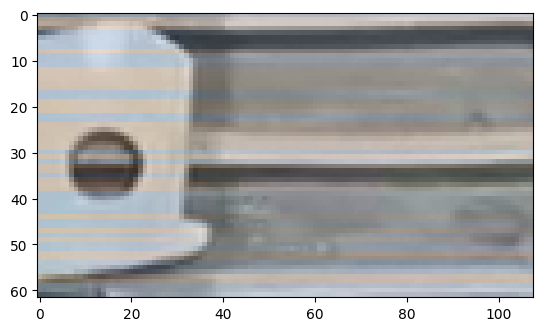

0 [4.176424e-05]


In [53]:
import matplotlib.pyplot as plt

i = 13

plt.imshow(X_test[i][:,:,:,0])
plt.show()

print(y_test[i], y_pred[i])

In [40]:
model.save('models/model_v5.h5')

In [41]:
from tensorflow.keras.models import load_model

loaded_model = load_model('models/model_v5.h5')